In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
FLDR='drive/MyDrive/dogs-vs-cats/'

In [3]:
import os

In [4]:
files_zip_full=os.listdir(FLDR)

In [5]:
files_zip_full

['sampleSubmission.csv', 'test1.zip', 'train.zip']

In [6]:
train_data=files_zip_full[2]

In [7]:
train_data

'train.zip'

In [8]:
import zipfile

In [ ]:
Labels=[]
Names=[]

archive=zipfile.ZipFile(FLDR+train_data)
for f_n in archive.namelist():
  print(f_n)
  if 'cat' in f_n or 'Cat' in f_n:
    Labels.append('cat')
    Names.append(f_n.split('/')[1])
  if 'dog' in f_n or 'Dog' in f_n:
    Labels.append('dog')
    Names.append(f_n.split('/')[1])
  archive.extract(f_n,FLDR+'extracted')
  


In [10]:
import pandas as pd


In [11]:
df_train=pd.DataFrame(list(zip(Names,Labels)),columns=['Files','Labels'])

In [12]:
df_train=df_train[1:]

In [13]:
df_train.head()

,Files,Labels
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
5,cat.10000.jpg,cat


In [14]:
df_train['Labels'].value_counts()

dog    12500
cat    12499
Name: Labels, dtype: int64

In [15]:
files_zip_full=os.listdir(FLDR)

In [16]:
files_zip_full

['sampleSubmission.csv', 'test1.zip', 'train.zip', 'extracted']

In [17]:
test_Sub=files_zip_full[0]

In [18]:
df_sub=pd.read_csv(FLDR+test_Sub)

In [19]:
df_sub.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [20]:
test_data=files_zip_full[1]

In [21]:
test_data

'test1.zip'

In [ ]:
archive=zipfile.ZipFile(FLDR+test_data)
for f_n in archive.namelist():
  print(f_n)
  archive.extract(f_n,FLDR+'extracted_2')

In [23]:
def replace_name(name):
  name=str(name)+'.jpg'
  return name

In [24]:
df_sub['id']=df_sub['id'].apply(replace_name)

In [25]:
df_sub.tail()

,id,label
12495,12496.jpg,0
12496,12497.jpg,0
12497,12498.jpg,0
12498,12499.jpg,0
12499,12500.jpg,0


In [26]:
def replace_labels(name):
  return 'cat' if (name==0) else 'dog'

In [27]:
df_sub['label']=df_sub['label'].apply(replace_labels)

In [28]:
df_sub.head()

,id,label
0,1.jpg,cat
1,2.jpg,cat
2,3.jpg,cat
3,4.jpg,cat
4,5.jpg,cat


In [39]:
from sklearn.model_selection import train_test_split
train,val= train_test_split(df_train, test_size=0.1)

In [40]:
train.head()

,Files,Labels
5786,cat.3956.jpg,cat
20723,dog.6149.jpg,dog
13415,dog.10820.jpg,dog
17067,dog.2859.jpg,dog
17200,dog.2979.jpg,dog


In [41]:
train.to_csv(FLDR+'Train.csv',index=False)
val.to_csv(FLDR+'Validate.csv',index=False)
df_sub.to_csv(FLDR+'Test.csv',index=False)

In [42]:
import pandas as pd

In [ ]:
train=pd.read_csv(FLDR+'Train.csv')
val=pd.read_csv(FLDR+'Validate.csv')
df_sub=pd.read_csv(FLDR+'Test.csv')

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
train_set=ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    shear_range=0.2,
)

In [45]:
val_set=ImageDataGenerator()

In [46]:
train_gen=train_set.flow_from_dataframe(
    train,
    directory=FLDR+'extracted/train/',
    x_col='Files',
    y_col='Labels',
    batch_size=16,
    class_mode='binary',
    target_size=(224, 224),
)

Found 22499 validated image filenames belonging to 2 classes.


In [47]:
val_gen=val_set.flow_from_dataframe(
    val,
    directory=FLDR+'extracted/train/',
    x_col='Files',
    y_col='Labels',
    batch_size=16,
    class_mode='binary',
    target_size=(224, 224),
)

Found 2500 validated image filenames belonging to 2 classes.


In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [56]:
def model(shape=(224,224,3)):
  input_tensor=Input(shape=shape)             

  base_model = ResNet50V2(weights="imagenet", include_top=False, input_tensor=input_tensor)   

  layer_1=Flatten()(base_model.output)
  layer_2=Dense(512, activation='relu')(layer_1)
  layer_2_d=Dropout(0.3)(layer_2)
  output=Dense(1, activation='sigmoid')(layer_2_d)

  model = Model(inputs=base_model.input, outputs=output)

  for layer in model.layers:
    layer.trainable = True
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizers.Adam(lr=0.01), loss='binary_crossentropy',metrics=['accuracy'])
  return model


In [57]:
Model=model()

In [59]:
Model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint(FLDR+"Model.h5", monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]
history = Model.fit_generator(train_gen, validation_data = val_gen, steps_per_epoch=50, callbacks=callbacks_list,verbose=1,epochs = 50)

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [63]:
def model(shape=(224,224,3)):
  input_tensor=Input(shape=shape)             

  base_model = VGG16(weights="imagenet", include_top=False, input_tensor=input_tensor)   

  layer_1=Flatten()(base_model.output)
  layer_2=Dense(512, activation='relu')(layer_1)
  layer_2_d=Dropout(0.3)(layer_2)
  output=Dense(1, activation='sigmoid')(layer_2_d)

  model = Model(inputs=base_model.input, outputs=output)

  for layer in model.layers:
    layer.trainable = True
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizers.Adam(lr=0.01), loss='binary_crossentropy',metrics=['accuracy'])
  return model


In [64]:
Model=model()

58892288/58889256 [==============================] - 0s 0us/step


In [65]:
Model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [66]:
checkpoint = ModelCheckpoint(FLDR+"Model.h5", monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]
history = Model.fit_generator(train_gen, validation_data = val_gen, steps_per_epoch=50, callbacks=callbacks_list,verbose=1,epochs = 50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 25s 448ms/step - loss: 261.5785 - accuracy: 0.7503 - val_loss: 27.4158 - val_accuracy: 0.9428
Epoch 2/50
50/50 [==============================] - 21s 432ms/step - loss: 28.3273 - accuracy: 0.9259 - val_loss: 13.0929 - val_accuracy: 0.9308
Epoch 3/50
50/50 [==============================] - 21s 428ms/step - loss: 6.7919 - accuracy: 0.9458 - val_loss: 3.4825 - val_accuracy: 0.9624
Epoch 4/50
50/50 [==============================] - 22s 430ms/step - loss: 3.5229 - accuracy: 0.9370 - val_loss: 1.9076 - val_accuracy: 0.9548
Epoch 5/50
50/50 [==============================] - 21s 430ms/step - loss: 3.0951 - accuracy: 0.9196 - val_loss: 1.3164 - val_accuracy: 0.9596
Epoch 6/50
50/50 [==============================] - 21s 429ms/step - loss: 3.9877 - accuracy: 0.9162 - val_loss: 1.4385 - val_accuracy: 0.9444
Epoch 7/50
50/50 [==============================] - 21s 434ms/step - loss: 2.4474 - accuracy: 0.9060 - val_loss: 0.7746 - val_accuracy: 0

In [69]:
import matplotlib.pyplot as plt

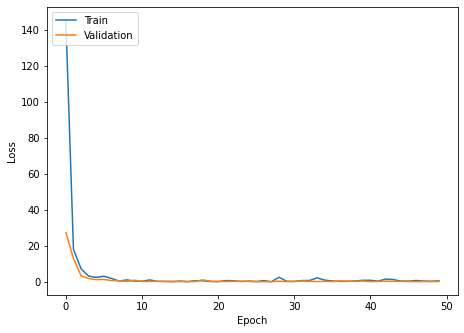

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [80]:
def model(shape=(224,224,3)):
  input_tensor=Input(shape=shape)             

  base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=input_tensor)   

  layer_1=Flatten()(base_model.output)
  layer_2=Dense(512, activation='relu')(layer_1)
  layer_2_d=Dropout(0.3)(layer_2)
  output=Dense(1, activation='sigmoid')(layer_2_d)

  model = Model(inputs=base_model.input, outputs=output)

  for layer in model.layers:
    layer.trainable = True
  model.compile(optimizer=optimizers.Adam(lr=0.01), loss='binary_crossentropy',metrics=['accuracy'])
  return model


In [81]:
Model=model()

In [82]:
Model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [83]:
checkpoint = ModelCheckpoint(FLDR+"Model.h5", monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]
history = Model.fit_generator(train_gen, validation_data = val_gen, steps_per_epoch=50, callbacks=callbacks_list,verbose=1,epochs = 50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 33s 523ms/step - loss: 25.8590 - accuracy: 0.5412 - val_loss: 411583152128.0000 - val_accuracy: 0.5032
Epoch 2/50
50/50 [==============================] - 25s 496ms/step - loss: 3.5603 - accuracy: 0.4677 - val_loss: 441977824.0000 - val_accuracy: 0.4968
Epoch 3/50
50/50 [==============================] - 23s 463ms/step - loss: 1.5863 - accuracy: 0.4933 - val_loss: 4691.9746 - val_accuracy: 0.4968
Epoch 4/50
50/50 [==============================] - 23s 463ms/step - loss: 0.7491 - accuracy: 0.5051 - val_loss: 14.6895 - val_accuracy: 0.4968
Epoch 5/50
50/50 [==============================] - 23s 464ms/step - loss: 0.6876 - accuracy: 0.5094 - val_loss: 0.7143 - val_accuracy: 0.5072
Epoch 6/50
50/50 [==============================] - 25s 497ms/step - loss: 0.6915 - accuracy: 0.5347 - val_loss: 0.6944 - val_accuracy: 0.5036
Epoch 7/50
50/50 [==============================] - 23s 462ms/step - loss: 0.7069 - accuracy: 0.4467 - val_loss: 0.745

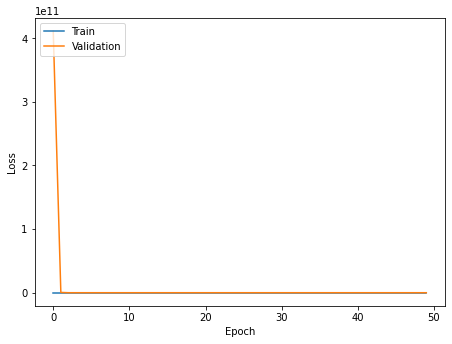

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()